In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from torchvision import datasets, transforms
import math, copy

In [2]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
fashion_mnist_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
fashion_mnist_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 1000
k = 10  # Number of classes
unbalance_factors = [0.1, 0.1, 0.1, 0.1, 1, 1, 0.1, 0.1, 0.1, 0.1]  # Define the proportions for each class

# Initialize list to hold data for each class
class_data = [[] for _ in range(k)]
for data, label in fashion_mnist_train:
    class_data[label].append(data)

# Make the classes unbalanced based on the defined unbalance factors
unbalanced_class_data = []
for i in range(k):
    total_samples = len(class_data[i])
    # Calculate the number of samples to keep for the class based on the unbalance factor
    samples_to_keep = int(total_samples * unbalance_factors[i])
    # Randomly select the subset of data
    selected_data = random.sample(class_data[i], samples_to_keep)
    unbalanced_class_data.append(torch.stack(selected_data))

# Create TensorDatasets for each class
tensor_datasets = [TensorDataset(data, torch.full((data.size(0),), label, dtype=torch.long)) for label, data in enumerate(unbalanced_class_data)]
fashion_mnist_train = torch.utils.data.ConcatDataset(tensor_datasets)

# Combine all training data for a single DataLoader
train_loader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the test data directly
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)

# Shuffle indices at the start of each epoch
def shuffle_class_data(tensor_datasets):
    shuffled_indices = []
    for dataset in tensor_datasets:
        num_samples = dataset.tensors[0].size(0)
        # Shuffle indices for the current class
        shuffled_indices.append(torch.randperm(num_samples))
    return shuffled_indices

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Define the Autoencoder model for image reconstruction
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * 32 * 32),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 3, 32, 32)  # Reshape to image size

In [4]:
criterion = nn.MSELoss()  # Use MSELoss for reconstruction error
N_total = sum(len(dataset) for dataset in tensor_datasets)

# Initialize training and test losses
epochs = 110
iterations = 5
M = int(np.floor(N_total / batch_size))  # Number of training batches
train_errors = np.zeros((epochs, iterations))
classical_errors = np.zeros((epochs, iterations))
test_errors = np.zeros((epochs, iterations))
classical_test_errors = np.zeros((epochs, iterations))
torch.manual_seed(42); model_base = Autoencoder()

for iters in range(iterations):
    # Initialize the model, criterion, and optimizer
    model = copy.deepcopy(model_base)
    for param, param_base in zip(model.parameters(), model_base.parameters()):
        param.data = param_base.data + torch.randn_like(param_base) * 5e-2  # Small noise perturbation
    model_l2m = copy.deepcopy(model)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    optimizer_l2m = optim.Adam(model_l2m.parameters(), lr=1e-5)
    alpha = torch.tensor([len(dataset) / N_total for dataset in tensor_datasets], dtype=torch.float32)
    classical_alpha = torch.tensor([len(dataset) / N_total for dataset in tensor_datasets], dtype=torch.float32)
    alpha_lr = 1e-1

    # Training loop
    for epoch in range(epochs):
        l2m_loss = 0; classical_loss = 0; total = 0; l2m_test_loss = 0; classical_test_loss = 0; total_test = 0;
        prev_indices = np.zeros(k, dtype=int)
        tracking_error = np.zeros(k, dtype=float)
        shuffled_indices = shuffle_class_data(tensor_datasets)

        # Learn2Mix Training
        model_l2m.train()
        for j in range(M):  # For each batch in an epoch
            combined_images = []
            for i in range(k):  # For each dataset
                num_samples = max(int(alpha[i].item() * batch_size), 0)  # Number of samples from dataset 'i'
                data_list = []; labels_list = []; remaining = num_samples
                while remaining > 0:
                    available = len(tensor_datasets[i]) - prev_indices[i]
                    take = min(available, remaining)
                    indices = shuffled_indices[i][prev_indices[i]:prev_indices[i] + take]
                    data_list.append(tensor_datasets[i].tensors[0][indices])
                    labels_list.append(tensor_datasets[i].tensors[1][indices])
                    
                    # Update the remaining samples and the previous index, and wrap around if the end of the dataset is reached
                    remaining -= take; prev_indices[i] += take
                    if prev_indices[i] >= len(tensor_datasets[i]): prev_indices[i] = 0  # Reset to start

                # Concatenate all collected data
                combined_images.append(torch.cat(data_list, dim=0))

            # Inner optimization step: update model parameters
            optimizer_l2m.zero_grad()
            x_mixed = torch.cat(combined_images, dim=0)
            z_mixed = model_l2m(x_mixed)
            loss = criterion(z_mixed, x_mixed)      
            loss.backward()
            optimizer_l2m.step()

            # Compute class-wise losses
            start_idx = 0
            for i in range(k):
                num_samples = max(int(alpha[i].item() * batch_size), 0)  # Number of samples from dataset 'i'
                tracking_error[i] = criterion(z_mixed[start_idx:start_idx + num_samples], x_mixed[start_idx:start_idx + num_samples])
                start_idx += num_samples

        # Outer optimization step: update alpha based on dataset-specific losses
        rewards = tracking_error / np.sum(tracking_error)
        alpha += alpha_lr * (torch.tensor(rewards) - alpha)

        # # Fixed weights training
        # model.train()
        # for j in range(M):  # For each batch in an epoch
        #     combined_images = []
        #     for i in range(k):  # For each dataset
        #         num_samples = max(int(classical_alpha[i].item() * batch_size), 0)  # Number of samples from dataset 'i'
        #         data_list = []; labels_list = []; remaining = num_samples
        #         while remaining > 0:
        #             available = len(tensor_datasets[i]) - prev_indices[i]
        #             take = min(available, remaining)
        #             indices = shuffled_indices[i][prev_indices[i]:prev_indices[i] + take]
        #             data_list.append(tensor_datasets[i].tensors[0][indices])
        #             labels_list.append(tensor_datasets[i].tensors[1][indices])
                    
        #             # Update the remaining samples and the previous index, and wrap around if the end of the dataset is reached
        #             remaining -= take; prev_indices[i] += take
        #             if prev_indices[i] >= len(tensor_datasets[i]): prev_indices[i] = 0  # Reset to start

        #         # Concatenate all collected data
        #         combined_images.append(torch.cat(data_list, dim=0))

        #     # Inner optimization step: update model parameters
        #     optimizer.zero_grad()
        #     x_mixed = torch.cat(combined_images, dim=0)
        #     z_mixed = model(x_mixed)
        #     loss = criterion(z_mixed, x_mixed)
        #     loss.backward()
        #     optimizer.step()

        # Classical Autoencoder Training
        model.train()
        for X_train, _ in train_loader:
            optimizer.zero_grad()
            classical_outputs = model(X_train)
            loss = criterion(classical_outputs, X_train)
            loss.backward()
            optimizer.step()

        # Computing Train Error
        model.eval(); model_l2m.eval();
        with torch.no_grad():
            classical_loss = 0; learn2mix_loss = 0
            for X_train, _ in train_loader:
                train_outputs = model_l2m(X_train)
                classical_outputs = model(X_train)

                total += X_train.size(0)
                l2m_loss += F.mse_loss(train_outputs, X_train, reduction='sum').item()
                classical_loss += F.mse_loss(classical_outputs, X_train, reduction='sum').item()

        # Computing Test Error
        model.eval(); model_l2m.eval();
        with torch.no_grad():
            for X_test, _ in test_loader:
                test_outputs = model_l2m(X_test)
                classical_outputs = model(X_test)

                total_test += X_test.size(0)
                l2m_test_loss += F.mse_loss(test_outputs, X_test, reduction='sum').item()
                classical_test_loss += F.mse_loss(classical_outputs, X_test, reduction='sum').item()

        train_errors[epoch, iters] = l2m_loss / total       
        classical_errors[epoch, iters] = classical_loss / total
        test_errors[epoch, iters] = l2m_test_loss / total_test
        classical_test_errors[epoch, iters] = classical_test_loss / total_test

        if epoch % 1 == 0:
            print(f"Iter {iters}, Epoch {epoch}, Cls Error: {classical_test_errors[epoch, iters]:.3f}, L2M Error: {test_errors[epoch, iters]:.3f}, Alpha: {np.round(alpha.detach().numpy(),3)}")

Iter 0, Epoch 0, Cls Error: 207.457, L2M Error: 207.455, Alpha: [0.044 0.042 0.04  0.043 0.329 0.332 0.041 0.042 0.043 0.044]
Iter 0, Epoch 1, Cls Error: 203.720, L2M Error: 203.703, Alpha: [0.049 0.049 0.045 0.048 0.304 0.309 0.046 0.048 0.049 0.052]
Iter 0, Epoch 2, Cls Error: 201.643, L2M Error: 201.604, Alpha: [0.055 0.056 0.049 0.054 0.282 0.288 0.051 0.054 0.053 0.059]
Iter 0, Epoch 3, Cls Error: 200.483, L2M Error: 200.424, Alpha: [0.06  0.063 0.052 0.059 0.262 0.269 0.054 0.059 0.057 0.064]
Iter 0, Epoch 4, Cls Error: 199.755, L2M Error: 199.678, Alpha: [0.065 0.069 0.056 0.063 0.244 0.252 0.059 0.062 0.062 0.069]
Iter 0, Epoch 5, Cls Error: 199.248, L2M Error: 199.158, Alpha: [0.07  0.073 0.059 0.068 0.227 0.237 0.062 0.065 0.066 0.074]
Iter 0, Epoch 6, Cls Error: 198.874, L2M Error: 198.770, Alpha: [0.074 0.077 0.062 0.071 0.212 0.223 0.064 0.069 0.069 0.079]
Iter 0, Epoch 7, Cls Error: 198.574, L2M Error: 198.458, Alpha: [0.078 0.082 0.063 0.075 0.198 0.211 0.068 0.072 0.072

Mean DNN:       147.6493, STDEV DNN:      0.6245
Mean L2M:       143.6163, STDEV L2M:      0.7781


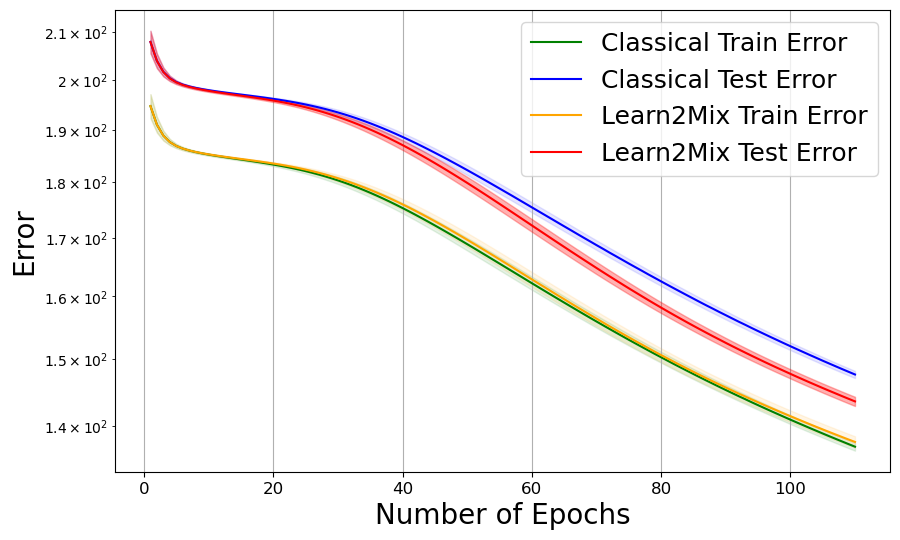

In [6]:
# Step 2: Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=0)
    std_error = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error of the mean
    stdev = np.std(data, axis=0)
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci, stdev

A = classical_errors.T[:,:]; B = train_errors.T[:,:]
mean_A, ci_A, stdev_A = compute_mean_and_CI(A)
mean_B, ci_B, stdev_B = compute_mean_and_CI(B)

X = classical_test_errors.T[:,:]; Z = test_errors.T[:,:]
mean_X, ci_X, stdev_X = compute_mean_and_CI(X)
mean_Z, ci_Z, stdev_Z = compute_mean_and_CI(Z)

print(f'Mean DNN:       {mean_X[len(mean_X)-1].round(4)}, STDEV DNN:      {stdev_X[len(stdev_X)-1].round(4)}')
print(f'Mean L2M:       {mean_Z[len(mean_Z)-1].round(4)}, STDEV L2M:      {stdev_Z[len(stdev_Z)-1].round(4)}')

# Step 3: Plot the results
epochs_all = list(range(1, X.shape[1] + 1))
plt.figure(figsize=(10, 6))

# Plotting for A
plt.fill_between(epochs_all, mean_A - ci_A, mean_A + ci_A, color='green', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_A, 'g-', label="Classical Train Error", zorder=20)

# Plotting for X
plt.fill_between(epochs_all, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_X, 'b-', label="Classical Test Error", zorder=20)

# Plotting for B
plt.fill_between(epochs_all, mean_B - ci_B, mean_B + ci_B, color='orange', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_B, '-', color='orange', label="Learn2Mix Train Error", zorder=20)

# Plotting for Z
plt.fill_between(epochs_all, mean_Z - ci_Z, mean_Z + ci_Z, color='red', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_Z, 'r-', label="Learn2Mix Test Error", zorder=30)

# Additional plot settings
plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Error", fontsize=20)
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 18},loc='upper right')
plt.grid(True)
plt.savefig('test.png', bbox_inches='tight')